# AOPLink & DataCure workflow

Uses:

AOP-Wiki RDF
- Extract information about AOP
- Find overlapping AOPs
- Find chemicals related to the MIE of the AOP (CAS and chemical names)


AOP-DB RDF
- Extract genes related to KEs of the AOP of interest
- For those genes, find the ToxCast assays related to them

ChemIdConvert
- Show chemical structures

Open TG-GATES API --> kept both the older API for finding samples, and the files that Tomaz provided
- Find compounds
- Find datasets with the chemicals of interest

WikiPathways --> using the largest set of significantly altered genes
- Print set of affected pathways




In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import re
import requests
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#For network figure
from pyvis.network import Network
from IPython.core.display import display, HTML


from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn2_circles

#chemidconvert
from IPython.display import display, HTML, IFrame
import urllib

#EdelWeiss DataExplorer
import simplejson as json
import pprint
from edelweiss_data import API, QueryExpression as Q

import seaborn as sns
#Pathway analysis
import statistics

# Set variables

In [2]:
#Define the AOP of interest
AOPid = "37"

#Define the SPARQL endpoint
aopwikisparql = SPARQLWrapper("http://aopwiki-rdf.prod.openrisknet.org/sparql/")
aopdbsparql = SPARQLWrapper("http://aopdb-rdf.prod.openrisknet.org/sparql/")
wikipathwayssparql = SPARQLWrapper("http://sparql.wikipathways.org/")

# BridgeDB base URL
bridgedb = 'http://bridgedb.prod.openrisknet.org/'

#Define the ChemIdConvert URL
chemidconvert = 'https://chemidconvert.cloud.douglasconnect.com/v1/'

# AOP-Wiki RDF

## Service description
The AOP-Wiki repository is part of the AOP Knowledge Base (AOP-KB), a joint effort of the US-Environmental Protection Agency and European Commission - Joint Research Centre. It is developed to facilitate collaborative AOP development, storage of AOPs, and therefore allow reusing toxicological knowledge for risk assessors. This Case Study has converted the AOP-Wiki XML data into an RDF schema, which has been exposed in a public SPARQL endpoint in the OpenRiskNet e-infrastructure.

## Implementation

Selected AOP: 37

2 ways of accessing data: 
SPARQL endpoint
API


In [3]:
#General info about AOP:

title = 'dc:title'
webpage = 'foaf:page'
creator = 'dc:creator'
abstract = 'dcterms:abstract'
key_event = 'aopo:has_key_event'
molecular_initiating_event = 'aopo:has_molecular_initiating_event'
adverse_outcome = 'aopo:has_adverse_outcome'
key_event_relationship = 'aopo:has_key_event_relationship'
stressor = 'ncit:C54571'
listofterms = [title,webpage,creator,abstract,key_event,molecular_initiating_event,adverse_outcome,key_event_relationship,stressor]

AOPinfo = pd.DataFrame(columns=['Properties'], index = [listofterms])

for term in listofterms:
    sparqlquery = '''
    PREFIX ncit: <http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#>
    SELECT (group_concat(distinct ?item;separator=";") as ?items)
    WHERE{
    ?AOP_URI a aopo:AdverseOutcomePathway;'''+term+''' ?item.
    FILTER (?AOP_URI = aop:'''+AOPid +''')}
    '''
    aopwikisparql.setQuery(sparqlquery)
    aopwikisparql.setReturnFormat(JSON)  
    results = aopwikisparql.query().convert()
    for result in results["results"]["bindings"]:
        AOPinfo.at[term,'Properties'] = result["items"]["value"]
display(AOPinfo)

,Properties
dc:title,PPARalpha-dependent liver cancer
foaf:page,http://identifiers.org/aop/37
dc:creator,"J. Christopher Corton, Cancer AOP Workgroup. National Health and Environmental Effects Research Laboratory, Office of Research and Development, Integrated Systems Toxicology Division, US Environmental Protection Agency, Research Triangle Park, NC. Corresponding author for wiki entry (corton.chris@epa.gov)\n"
dcterms:abstract,"Several therapeutic agents and industrial chemicals induce liver tumors in rats and mice through the activation of the peroxisome proliferator-activated receptor alpha (PPARa). The molecular and cellular events by which PPARa activators induce rodent hepatocarcinogenesis have been extensively studied and elucidated. The weight of evidence relevant to the hypothesized AOP for PPARa activator-induced rodent hepatocarcinogenesis is summarized here. Chemical-specific and mechanistic data support concordance of temporal and dose&ndash;response relationships for the key events associated with many PPARa activators including a phthalate ester plasticizer di(2-ethylhexyl)phthalate (DEHP) and the drug gemfibrozil. The key events (KE) identified are KE1&ndash;PPARa activation, KE2&ndash;alteration in cell growth pathways, KE3&ndash;perturbation of cell growth and survival including increases in cell proliferation and effects on apoptosis, KE4&ndash;selective clonal expansion of preneoplastic foci cells, which lead to the Adverse Outcome&ndash;increases in hepatocellular adenomas and carcinomas. A number of molecular events were identified which were initially evaluated as possible key events. However, the data were not convincing for these to be key events in the MOA. Rather, although not causal these modulating factors were considered to have the potential to alter the ability of PPARa activators to increase liver cancer. These modulating events include increases in oxidative stress, activation of NF-kB, and inhibition of gap junction intercellular communication. While biologically plausible in humans, the hypothesized key events in the rodent MOA, for PPARa activators, are unlikely to induce liver tumors in humans because of biological differences in responses. This conclusion is based on minimal or no effects observed on growth pathways, hepatocellular proliferation and liver tumors in humans and/or species (including hamsters, guinea pigs and cynomolgous monkeys) that are more appropriate human surrogates than mice and rats at overlapping dose levels.\n"
aopo:has_key_event,http://identifiers.org/aop.events/1170;http://identifiers.org/aop.events/1171;http://identifiers.org/aop.events/227;http://identifiers.org/aop.events/716;http://identifiers.org/aop.events/719
aopo:has_molecular_initiating_event,http://identifiers.org/aop.events/227
aopo:has_adverse_outcome,http://identifiers.org/aop.events/719
aopo:has_key_event_relationship,http://identifiers.org/aop.relationships/1229;http://identifiers.org/aop.relationships/1230;http://identifiers.org/aop.relationships/1232;http://identifiers.org/aop.relationships/1239
ncit:C54571,http://identifiers.org/aop.stressor/11;http://identifiers.org/aop.stressor/175;http://identifiers.org/aop.stressor/191;http://identifiers.org/aop.stressor/205;http://identifiers.org/aop.stressor/206;http://identifiers.org/aop.stressor/207;http://identifiers.org/aop.stressor/208;http://identifiers.org/aop.stressor/210;http://identifiers.org/aop.stressor/211


In [4]:
#generate network from AOP + interlinked AOPs.

Key_Events = str(AOPinfo.iat[4,0]).split(';')
#from the KEs, get the AOPs
for Key_Event in Key_Events:
    sparqlquery = '''
    SELECT ?MIE_ID ?KE_ID ?AO_ID ?KER_ID ?KE_Title
    WHERE{
    ?KE_URI a aopo:KeyEvent; dcterms:isPartOf ?AOP_URI.
    ?AOP_URI aopo:has_key_event ?KE_URI2; aopo:has_molecular_initiating_event ?MIE_URI; aopo:has_adverse_outcome ?AO_URI; aopo:has_key_event_relationship ?KER_URI.
    ?KE_URI2 rdfs:label ?KE_ID; dc:title ?KE_Title. 
    ?MIE_URI rdfs:label ?MIE_ID.
    ?AO_URI rdfs:label ?AO_ID.
    ?KER_URI rdfs:label ?KER_ID.    
    FILTER (?KE_URI = <'''+Key_Event+'''>)}
    '''
    aopwikisparql.setQuery(sparqlquery)
    aopwikisparql.setReturnFormat(JSON)  
    results = aopwikisparql.query().convert()

    MIEs = set([])
    KEs = set([])
    KEtitle = {}
    AOs = set([])
    KERs = set([])
    for result in results["results"]["bindings"]:
        MIEs.add(result["MIE_ID"]["value"])
        AOs.add(result["AO_ID"]["value"])
        KEs.add(result["KE_ID"]["value"])
        KERs.add(result["KER_ID"]["value"])
        KEtitle[result["KE_ID"]["value"]]=result["KE_Title"]["value"]
#list all KEs, MIEs and AOs separately
KEs2 = []
for item in KEs:
    if item not in MIEs and item not in AOs:
        KEs2.append(item) 

    
net= Network(height="100%", width="100%")
for MIE in MIEs:
    net.add_node(MIE, color = 'lightgreen', size = 50, shape = 'circle', font = '20px arial black', title = KEtitle[MIE])
for KE in KEs2:
    net.add_node(KE, color = 'khaki', size = 50, shape = 'circle', font = '20px arial black', title = KEtitle[KE])
for AO in AOs:
    net.add_node(AO, color = 'salmon', size = 50, shape = 'circle', font = '20px arial black', title = KEtitle[AO])

for KER in KERs:
    sparqlquery = '''
    SELECT ?KE_UP_ID ?KE_DOWN_ID 
    WHERE{
    ?KER_URI a aopo:KeyEventRelationship; rdfs:label ?KER_ID; aopo:has_upstream_key_event ?KE_UP_URI; aopo:has_downstream_key_event ?KE_DOWN_URI.
    ?KE_UP_URI rdfs:label ?KE_UP_ID.
    ?KE_DOWN_URI rdfs:label ?KE_DOWN_ID.
    FILTER (?KER_ID = "'''+KER+'''")}
    '''
    aopwikisparql.setQuery(sparqlquery)
    aopwikisparql.setReturnFormat(JSON)  
    results = aopwikisparql.query().convert()
    for result in results["results"]["bindings"]:
        net.add_edge(result["KE_UP_ID"]["value"],result["KE_DOWN_ID"]["value"],width = 2, color = 'black',label = KER, arrows = 'to')

net.show('mygraph.html')
IFrame(src='./mygraph.html', width=700, height=600)

In [5]:
sparqlquery = '''
PREFIX ncit: <http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#>
SELECT ?CAS_ID (fn:substring(?CompTox,33) as ?CompTox_ID)
WHERE{
?AOP_URI a aopo:AdverseOutcomePathway; ncit:C54571 ?Stressor.
?Stressor aopo:has_chemical_entity ?Chemical.
?Chemical cheminf:CHEMINF_000446 ?CAS_ID.
OPTIONAL {?Chemical cheminf:CHEMINF_000568 ?CompTox.}
FILTER (?AOP_URI = aop:'''+AOPid +''')}
'''
aopwikisparql.setQuery(sparqlquery)
aopwikisparql.setReturnFormat(JSON)  
results = aopwikisparql.query().convert()

Chemical_names = {}



for result in results["results"]["bindings"]:
    try: Chemical_names[result["CAS_ID"]["value"]] =result["CompTox_ID"]["value"]
    except: pass

Chemdata = pd.DataFrame(columns=['CAS_ID','CompTox_ID'])
for CAS_ID in Chemical_names:
    Chemdata = Chemdata.append({
        'CAS_ID'        : CAS_ID,
        'CompTox_ID': Chemical_names[CAS_ID],
        }, ignore_index=True)
display(Chemdata)

,CAS_ID,CompTox_ID
0,117-81-7,DTXSID5020607
1,25812-30-0,DTXSID0020652
2,3771-19-5,DTXSID8020911
3,41859-67-0,DTXSID3029869
4,49562-28-9,DTXSID2029874
5,50892-23-4,DTXSID4020290
6,52214-84-3,DTXSID8020331
7,637-07-0,DTXSID3020336


In [6]:
compounds = set([])
for index, row in Chemdata.iterrows():
    compounds.add(row['CAS_ID'])
compounds

{'117-81-7',
 '25812-30-0',
 '3771-19-5',
 '41859-67-0',
 '49562-28-9',
 '50892-23-4',
 '52214-84-3',
 '637-07-0'}

# ChemIdConvert

## Service description
The ChemIdConverter allows users to submit and translate a variety of chemical descriptors, such as SMILES and InChI, through a REST API.

## Implementation

Convert selected chemical names and display their chemical structures


In [ ]:
compoundstable = pd.DataFrame(columns=['CAS_ID', 'Smiles', 'Image'])

# Fill "compounds" with the "smiles" by the compound name.
for compound in compounds:
    smiles = requests.get(chemidconvert + 'cas/to/smiles', params={'cas': compound}).json()['smiles']
    compoundstable = compoundstable.append({'CAS_ID': compound, 'Smiles': smiles, 'Image': smiles}, ignore_index=True)

def smiles_to_image_html(smiles):  # "smiles" shadows "smiles" from outer scope, use this function only in "to_html().
    """Gets for each smile the image, in HTML.
    :param smiles: Takes the “smiles” form “compounds”.
    :return: The HTML code for the image of the given smiles.
    """
    return '<img style="width:450px" src="' + chemidconvert+'asSvg?smiles='+urllib.parse.quote(smiles)+'"/>'


# Return a HTML table of "compounds", after "compounds" is fill by "smiles_to_image_html".
HTML(compoundstable.to_html(escape=False, formatters=dict(Image=smiles_to_image_html)))

# GRLC API

In [7]:
import io
aopwiki_api = 'http://grlc.io/api/marvinm2/AOPWikiQueries/'
chemforaop = 'get-chemicals-for-aop'
headers={'accept': 'text/csv'}
result = requests.get(aopwiki_api+chemforaop+'?aopfilter='+AOPid, headers = headers)
resultClean = io.StringIO(result.content.decode("utf-8"))
df = pd.read_csv(resultClean, sep = ",")
df = df.drop(['callret-1'], axis=1)
display(df)

,CASID
0,117-81-7
1,25812-30-0
2,3771-19-5
3,41859-67-0
4,49562-28-9
5,50892-23-4
6,52214-84-3
7,637-07-0


# AOP-DB RDF

## Service description
The EPA AOP-DB supports the discovery and development of putative and potential AOPs. Based on public annotations, it integrates AOPs with gene targets, chemicals, diseases, tissues, pathways, species orthology information, ontologies, and gene interactions. The AOP-DB facilitates the translation of AOP biological context, and associates assay, chemical and disease endpoints with AOPs (Pittman et al., 2018; Mortensen et al., 2018). The AOP-DB won the first OpenRiskNet implementation challenge of the associated partner program and is therefore integrated into the OpenRiskNet e-infrastructure. After the conversion of the AOP-DB into an RDF schema, its data will be exposed in a Virtuoso SPARQL endpoint.

## Implementation
Extract all genes related to AOP of interest
Find all ToxCast assays linked to those genes

In [8]:
Key_Events = str(AOPinfo.iat[4,0]).split(';')
Genes = []
#from the KEs, get the AOPs
for Key_Event in Key_Events:
    sparqlquery = '''
    SELECT DISTINCT ?KE_ID ?Entrez_ID WHERE{
    ?KE_URI edam:data_1027 ?Entrez_URI. ?Entrez_URI edam:data_1027 ?Entrez_ID.
    FILTER (?KE_URI = <'''+Key_Event +'''>)}
    '''
    aopdbsparql.setQuery(sparqlquery)
    aopdbsparql.setReturnFormat(JSON)  
    results = aopdbsparql.query().convert()
    for result in results["results"]["bindings"]:
        Genes.append(result["Entrez_ID"]["value"])
print(Genes)

['5465', '403654', '19013', '25747']


# BridgeDb to map identifiers

## Service description
In order to link databases and services that use particular identifiers for genes, proteins, and chemicals, the BridgeDb platform is integrated into the OpenRiskNet e-infrastructure. It allows for identifier mapping between various biological databases for data integration and interoperability (van Iersel et al., 2010).

## Implementation
The genes from AOP-DB are mapped to identifiers from other databases using BridgeDb. Variable values are filled for 'inputdatasource' and 'outputdatasource' identifiers based on BridgeDb's documentation on system codes: https://www.bridgedb.org/documentation/system-codes/. 

### provide short table with resources + code

Also, the species is specified as a value in the variable 'Species'.


In [9]:
inputdatasource = 'L'
outputdatasource = ['H','En']
Species = ['Human','Dog','Mouse','Rat']
Mappings = {}
HGNC = []

for source in outputdatasource:
    Mappings[source] = []
    for Entrez in Genes:
        for species in Species:
            allmappings = re.split('\t|\n', requests.get(bridgedb + species + '/xrefs/' + inputdatasource + '/' + Entrez + '?dataSource='+source).text)
            if allmappings[0] is not '':
                break
        Mappings[source].append(allmappings[0])

ids = {}
for source in Mappings:
    ids[source]=[]
    for identifier in Mappings[source]:
            ids[source].append(identifier)

GenesTable = pd.DataFrame(columns=['Entrez','HGNC','Ensembl'])
GenesTable['Entrez'] = Genes
GenesTable['HGNC'] = ids['H']
GenesTable['Ensembl'] = ids['En']

GenesTable

,Entrez,HGNC,Ensembl
0,5465,PPARA,ENSG00000186951
1,403654,,ENSCAFG00000000788
2,19013,,ENSMUSG00000022383
3,25747,,ENSRNOG00000021463


In [10]:
Assays = pd.DataFrame(columns=['Assay_ID', 'Assay_title', 'Entrez', 'Tissue', 'Species_name'])

for gene in Genes:
    sparqlquery = '''
    SELECT ?Assay_title ?Assay_ID ?Tissue ?Species_name WHERE{
    SELECT * WHERE{
    ?Assay a mmo:0000441; bao:BAO_0003064 ?Entrez_URI; rdfs:label ?Assay_title; foaf:group ?Assay_ID; uberon:0000061 ?Tissue; ncbitaxon:131567 ?Species_URI.
    SERVICE <http://aopwiki-rdf.prod.openrisknet.org/sparql/>{
    ?Species_URI dc:title ?Species_name.
    }
    FILTER (?Entrez_URI = ncbigene:'''+gene +''')}}
    '''
    aopdbsparql.setQuery(sparqlquery)
    aopdbsparql.setReturnFormat(JSON)  
    results = aopdbsparql.query().convert()
    for result in results["results"]["bindings"]:
        Assays = Assays.append({'Assay_ID' :  result["Assay_ID"]["value"],
                                'Assay_title' :  result["Assay_title"]["value"],
                                'Tissue'      :  result["Tissue"]["value"],
                                'Species_name'     :  result["Species_name"]["value"],
                                'Entrez'        :  gene}, ignore_index=True)
display(Assays)

,Assay_ID,Assay_title,Entrez,Tissue,Species_name
0,269,NVS_NR_hPPARa,5465,,Homo sapiens
1,6,ATG_TRANS,5465,liver,Homo sapiens
2,6,ATG_TRANS,5465,liver,Homo sapiens


In [11]:
Assay_IDs = set([])
for index, row in Assays.iterrows():
    Assay_IDs.add(row['Assay_ID'])
print(Assay_IDs)

{'269', '6'}


# Edelweiss DataExplorer

In [12]:
edelweiss_api_url = 'https://api.develop.edelweiss.douglasconnect.com'
api = API(edelweiss_api_url)
api.authenticate()

In [13]:
pattern = "^EPA-ToxCast"
#pattern = ".*"
columns = [
    #("Endpoint", "$.assay.component.endpoint"),
    ("Endpoint name", "$.assay.component.endpoint.assay_component_endpoint_name.value"),
    ("Biological target", "$.assay.component.endpoint.target.biological_process_target.value"),
    ("Entrez gene ID for the molecular target", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_entrez_gene_id.value"),
    ("Symbol", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_official_symbol.value"),
    ("Gene name", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_gene_name.value")]
condition = Q.search_anywhere("EPA-ToxCast")
ToxCast = api.get_published_datasets(limit=30000, columns=columns, condition=condition)
ToxCast.loc[~ToxCast['Entrez gene ID for the molecular target'].isin(Genes)]
ToxCast

,,dataset,Endpoint name,Biological target,Entrez gene ID for the molecular target,Symbol,Gene name
id,version,,,,,,
7ab126dd-3a66-4cec-938e-9121d1dd270a,1,<PublishedDataset '7ab126dd-3a66-4cec-938e-9121d1dd270a':1 - EPA-ToxCastV3.1-ATG_PPARa_TRANS_dn summary data>,"""ATG_PPARa_TRANS_dn""","""regulation of transcription factor activity""",5465,"""PPARA""","""peroxisome proliferator-activated receptor alpha"""
093c8220-a5cd-4fe0-8793-4ed032f09420,1,<PublishedDataset '093c8220-a5cd-4fe0-8793-4ed032f09420':1 - EPA-ToxCastV3.1-ATG_PPARa_TRANS_up summary data>,"""ATG_PPARa_TRANS_up""","""regulation of transcription factor activity""",5465,"""PPARA""","""peroxisome proliferator-activated receptor alpha"""
35341552-11f2-4db7-b76d-e6cf990bdc1e,1,<PublishedDataset '35341552-11f2-4db7-b76d-e6cf990bdc1e':1 - EPA-ToxCastV3.1-NVS_NR_hPPARa summary data>,"""NVS_NR_hPPARa""","""receptor binding""",5465,"""PPARA""","""peroxisome proliferator-activated receptor alpha"""


In [14]:
columns = [
    #("Metadata", "$"),
    ("Compound", "$.Compound.Name"),
    ("CAS", "$.Compound.CAS"),
    ("SMILES", "$.Compound.SMILES"),
    ("Organism", "$.Assay.Organism"),
    ("Study type", "$.Assay.\"Study type\""),
    ("Organ", "$.Assay.Organ"),
    ("Dose", "$.Assay.Exposure.Dose"),
    ("Dosing", "$.Assay.Dosing"),
    ("Duration", "$.Assay.Exposure.Duration")
]
condition = Q.search_anywhere("TG-GATES")
TGGATES = api.get_published_datasets(limit=30000, columns=columns, condition=condition)
TGGATES

,,dataset,Compound,CAS,SMILES,Organism,Study type,Organ,Dose,Dosing,Duration
id,version,,,,,,,,,,
22ac45eb-6de9-4dee-b854-7267295179a3,1,<PublishedDataset '22ac45eb-6de9-4dee-b854-7267295179a3':1 - TG-GATES-ORN_cs_aoplink_lofibrate_Rat_Liver_in vitro_2_hr_high_FOLD_CHANGES>,"""clofibrate""","[""637-07-0""]","""CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl""","""Rat""","""in_vitro""","""Liver""","""high""",null,2
e00f5f96-f576-42f3-95cc-933345de15e8,1,<PublishedDataset 'e00f5f96-f576-42f3-95cc-933345de15e8':1 - TG-GATES-ORN_cs_aoplink_gemfibrozil_Rat_Liver_in vivo_Single_24_hr_middle_FOLD_CHANGES>,"""gemfibrozil""","[""25812-30-0""]","""CC1=CC(=C(C=C1)C)OCCCC(C)(C)C(=O)O""","""Rat""","""in_vivo""","""Liver""","""middle""","""Single""",24
4af73282-76dd-426f-9b75-807d0a60149a,1,<PublishedDataset '4af73282-76dd-426f-9b75-807d0a60149a':1 - TG-GATES-ORN_cs_aoplink_lofibrate_Rat_Liver_in vivo_Single_9_hr_middle_FOLD_CHANGES>,"""clofibrate""","[""637-07-0""]","""CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl""","""Rat""","""in_vivo""","""Liver""","""middle""","""Single""",9
1b9fd80d-ec46-4466-ab8a-8ca316648091,1,<PublishedDataset '1b9fd80d-ec46-4466-ab8a-8ca316648091':1 - TG-GATES-ORN_cs_aoplink_gemfibrozil_Rat_Liver_in vivo_Repeat_8_day_low_FOLD_CHANGES>,"""gemfibrozil""","[""25812-30-0""]","""CC1=CC(=C(C=C1)C)OCCCC(C)(C)C(=O)O""","""Rat""","""in_vivo""","""Liver""","""low""","""Repeat""",8
8c69e59e-5077-484f-bbf5-092c1c72fde1,1,<PublishedDataset '8c69e59e-5077-484f-bbf5-092c1c72fde1':1 - TG-GATES-ORN_cs_aoplink_gemfibrozil_Rat_Liver_in vivo_Repeat_15_day_low_FOLD_CHANGES>,"""gemfibrozil""","[""25812-30-0""]","""CC1=CC(=C(C=C1)C)OCCCC(C)(C)C(=O)O""","""Rat""","""in_vivo""","""Liver""","""low""","""Repeat""",15
...,...,...,...,...,...,...,...,...,...,...,...
0eebd6af-f7c8-4285-bde5-b2f159c3710a,1,<PublishedDataset '0eebd6af-f7c8-4285-bde5-b2f159c3710a':1 - TG-GATES-ORN_cs_aoplink_fenofibrate_Rat_Liver_in vivo_Single_3_hr_low_FOLD_CHANGES>,"""fenofibrate""","[""49562-28-9""]","""CC(C)OC(=O)C(C)(C)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)Cl""","""Rat""","""in_vivo""","""Liver""","""low""","""Single""",3
0897348d-e5cc-49ab-8d07-da6f2a28f97e,1,<PublishedDataset '0897348d-e5cc-49ab-8d07-da6f2a28f97e':1 - TG-GATES-ORN_cs_aoplink_lofibrate_Rat_Kidney_in vivo_Repeat_4_day_low_FOLD_CHANGES>,"""clofibrate""","[""637-07-0""]","""CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl""","""Rat""","""in_vivo""","""Kidney""","""low""","""Repeat""",4
0da47350-0464-4b4f-9b1f-d142b61979b7,1,<PublishedDataset '0da47350-0464-4b4f-9b1f-d142b61979b7':1 - TG-GATES-ORN_cs_aoplink_fenofibrate_Rat_Liver_in vivo_Repeat_8_day_low_FOLD_CHANGES>,"""fenofibrate""","[""49562-28-9""]","""CC(C)OC(=O)C(C)(C)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)Cl""","""Rat""","""in_vivo""","""Liver""","""low""","""Repeat""",8


In [15]:
deg = []

dg2 = TGGATES[(TGGATES['Organism']=="\"Rat\"") & (TGGATES['Organ']=="\"Liver\"") & (TGGATES['Study type']=="\"in_vivo\"")  & (TGGATES['Dosing']=="\"Repeat\"") & (TGGATES['Dose'] == "\"high\"")]
for index, row in dg2.iterrows():
    file = row['dataset'].get_data(limit=100000)
    assay_deg = file[((file['logFC'] > 1) | (file['logFC'] < -1)) & (file['P.Value'] < 0.05) ]['SYMBOL'].unique().tolist()
    if len(assay_deg) > 0:
        for gene in assay_deg:
            deg.append(gene)

# filter only unique genes
deg = list(set(deg))
print('Number of differentially expressed genes: '+str(len(deg))) 

dgnew = dg2.copy()
for index, row in dg2.iterrows():
    
    file = row['dataset'].get_data(limit=100000)
    for gene in deg:
        result = file[file['SYMBOL'] == gene].mean()['logFC']
        dgnew.at[index, str(gene)] = result


Number of differentially expressed genes: 300


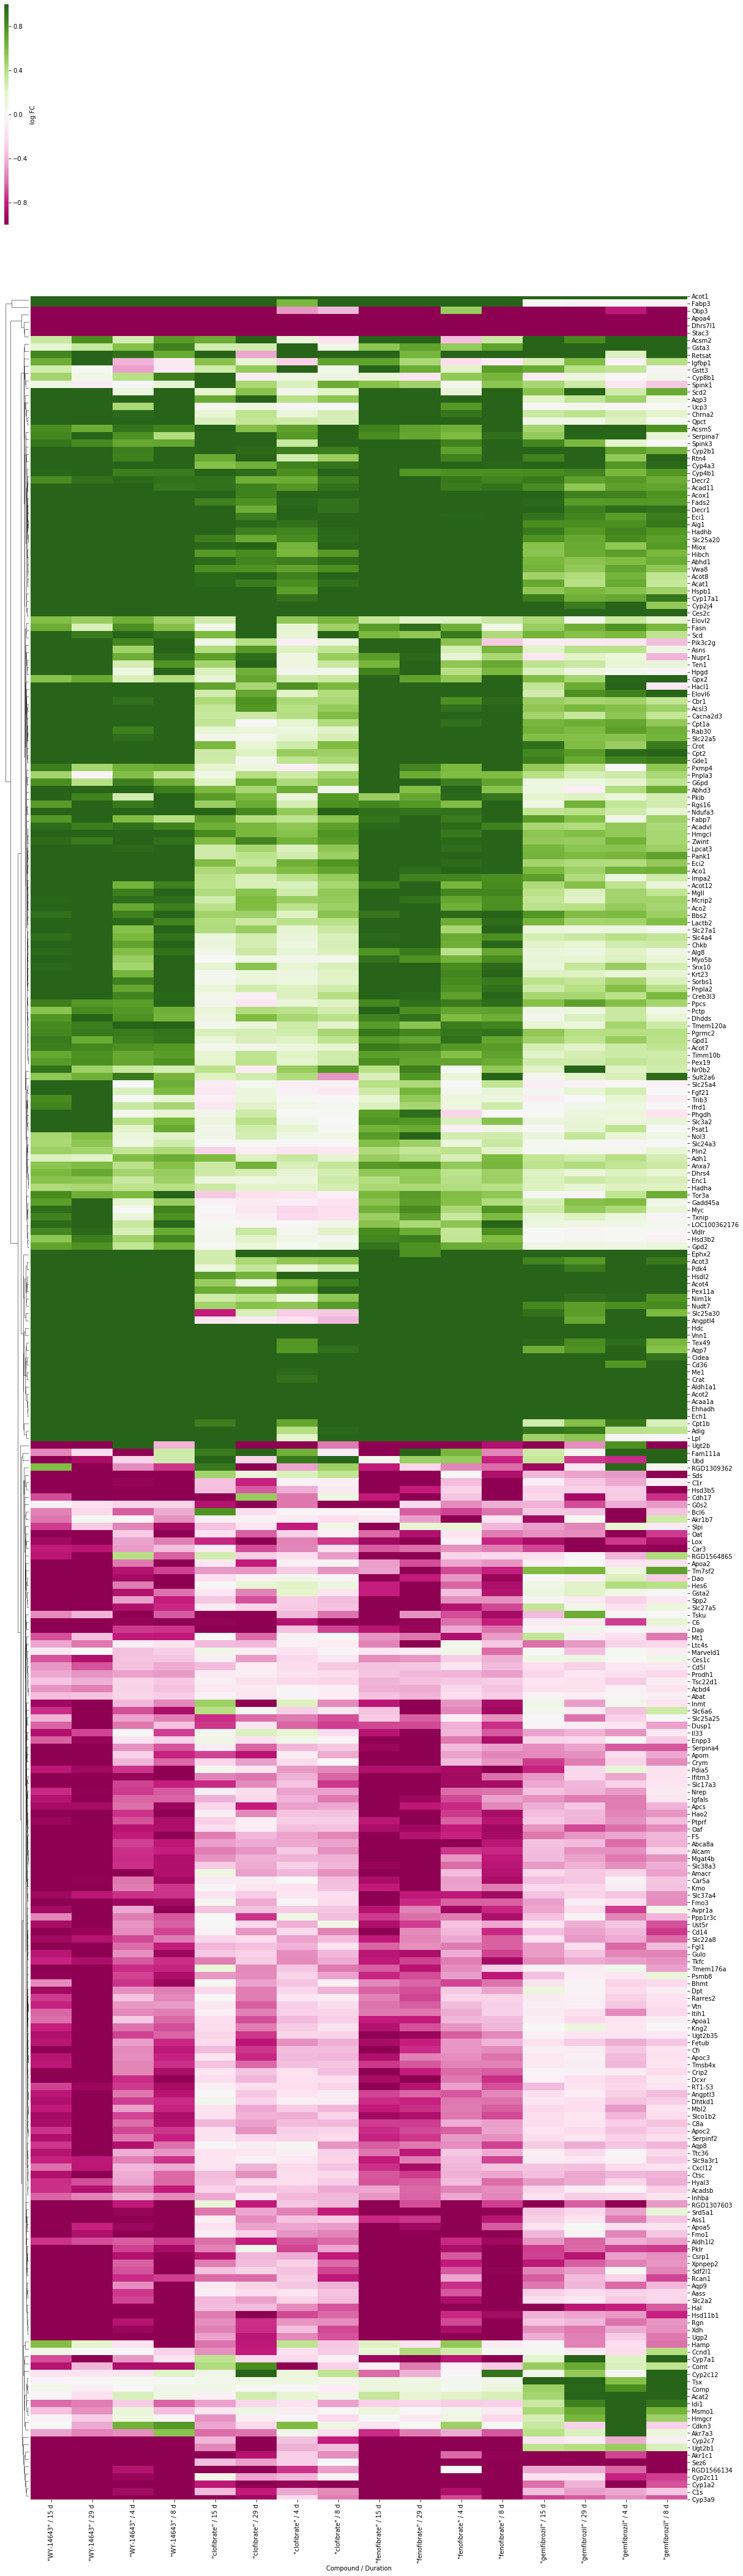

In [16]:
dgplot = dgnew[(dgnew['Dose'] == "\"high\"")].copy()
dgplot = dgplot.sort_values(by=['Compound', 'Duration'])
dgplot['Compound / Duration'] = dgplot['Compound'] + ' / ' + dgplot['Duration'].astype(str) + ' d'
dgplot = dgplot.set_index('Compound / Duration')
dgplot = dgplot.iloc[:, 9:]

dgplot = dgplot.T.dropna(axis=0, how='any')
dgplot = dgplot[1:]

ax = sns.clustermap(dgplot.fillna(0), figsize=(20,(len(deg)/4)), cmap='PiYG', vmin=-1, vmax=1, annot=False,  fmt='.2f', cbar_kws={'label': 'log FC'}, col_cluster=False)

ax.savefig('rat_invivo_liver_repeat_high.png')

# WikiPathways RDF

## Service description
WikiPathways is a community-driven molecular pathway database, supporting wide-spread topics and supported by many databases and integrative resources. It contains semantic annotations in its pathways for genes, proteins, metabolites, and interactions using a variety of reference databases, and WikiPathways is used to analyze and integrate experimental omics datasets (Slenter et al., 2017). Furthermore, human pathways from Reactome (Fabregat et al., 2018), another molecular pathway database, are integrated with WikiPathways and are therefore part of the WikiPathways RDF (Waagmeester et al., 2016). On the OpenRiskNet e-infrastructure, the WikiPathways RDF, which includes the Reactome pathways, is exposed via a Virtuoso SPARQL endpoint.

## Implementation


In [17]:
OrganismFilter = 'Rattus norvegicus'

sparqlquery = '''
    SELECT DISTINCT (str(?wpid) as ?Pathway_ID) (str(?PW_Title) as ?Pathway_title) (fn:substring(?ncbiGeneId,33) as ?Entrez) 
    WHERE {
    ?gene a wp:GeneProduct; dcterms:identifier ?id; dcterms:isPartOf ?pathwayRes; wp:bdbEntrezGene ?ncbiGeneId.
    ?pathwayRes a wp:Pathway; dcterms:identifier ?wpid; dc:title ?PW_Title; wp:organismName "'''+OrganismFilter+'''"^^xsd:string.}
    '''
wikipathwayssparql.setQuery(sparqlquery)
wikipathwayssparql.setReturnFormat(JSON)  
results = wikipathwayssparql.query().convert()

WikiPathwaysGenes = {}
WikiPathwaysNames = {}
for result in results["results"]["bindings"]:
    WikiPathwaysGenes[result["Pathway_ID"]["value"]] = set([])
for result in results["results"]["bindings"]:
    WikiPathwaysNames[result["Pathway_ID"]["value"]] = result["Pathway_title"]["value"]
for result in results["results"]["bindings"]:
    WikiPathwaysGenes[result["Pathway_ID"]["value"]].add(result["Entrez"]["value"])

for lst in WikiPathwaysGenes:
    WikiPathwaysGenes[lst] = [WikiPathwaysGenes[lst],len(WikiPathwaysGenes[lst])]

WPtable = pd.DataFrame.from_dict(WikiPathwaysGenes,orient='index',columns=['Genes','nGenes'])
display(WPtable)

,Genes,nGenes
WP1286,"{108348148, 171341, 64305, 286954, 25279, 154985, 362228, 25428, 499422, 246245, 25429, 24294, 113992, 64352, 108348061, 24422, 116631, 681913, 140568, 364476, 64570, 494499, 246767, 288108, 29633, 316325, 100910462, 24404, 83783, 316435, 690050, 116686, 25086, 29326, 396551, 302302, 29328, 29725, 246248, 307859, 24426, 685402, 24192, 81924, 293779, 292915, 25256, 24421, 499302, 301264, 24297, 154516, 361510, 24902, 24861, 24424, 25315, 290623, 65030, 292155, 24298, 299566, 294449, 361631, 25426, 368066, 29680, 363618, 291770, 116632, 311257, 308445, 499689, 295934, 289197, 24267, 100910526, 65185, 303218, 574523, 58953, 25458, 58981, 103690051, 25147, 684979, 308511, 297029, 310848, 54246, 302489, 307838, 361718, 500257, 314694, 24912, 171072, 25427, 498489, 25355, ...}",143
WP124,"{25303, 4864, 501233, 1576, 24565, 100910144, 396551, 1577, 301595, 574523, 100125372, 29225, 171118, 501232, 396527, 396552, 24346, 113992, 312382, 154516, 24861, 100365112, 108348093, 65036, 54575}",25
WP348,"{301323, 680111, 314856, 308937, 246060, 311562, 313479, 116651, 299112, 313978, 291885, 29728, 362817, 24577, 114483, 94201, 291105, 81646, 295596, 54237, 291927, 246327, 25737, 114851, 100363500, 362165, 300711, 361178, 684111, 59102, 406169, 25203, 100360427, 314638, 288532, 83571, 171102, 316273, 171150, 25112, 362304, 295052, 310616, 24708, 300947, 29685, 399489, 313138, 287961, 58919, 266713, 25164, 301430, 312538, 298400, 85242, 24842, 362291, 25193, 84389, 29157, 362485, 304573, 64033, 54238, 25729, 287524}",67
WP1278,"{246756, 360640, 84351, 29538, 103694380, 309452, 81736, 116554, 309361, 299331, 313121, 311245, 116590, 81780, 309165, 286908, 24481}",17
WP1312,"{29414, 289021, 60399, 29733, 60352, 114509, 84431, 25643, 25686, 81664, 85240, 306792, 83537, 29322, 24185, 100912585, 25233, 54268, 308589, 29415, 170897, 24654, 58840, 50689, 315298, 116590}",26
...,...,...
WP323,"{24379, 24443, 246281, 25120, 290567, 83817, 24848, 24311, 25085, 25699, 24661, 24380, 24267, 24616, 29253}",15
WP513,"{24311, 25699, 24661, 25085, 24616}",5
WP1292,"{444985, 288259, 315763, 85309, 689330, 64365, 680308, 84350, 299857, 287379, 29261, 361472, 312192, 362657, 81508, 29443, 64300, 300886, 89833, 25331, 81643, 290947, 444984, 24312, 64392, 81522, 306586}",27
WP146,"{365320, 25502, 24312, 84596, 85472, 24689, 289276, 29240, 83782, 299976, 302642, 29562, 59294, 362329, 362720, 24465, 315150, 680308}",18


# Pathway selection
First, extract list of differentially expressed genes

In [18]:
deg = []

dg2 = TGGATES[(TGGATES['Organism']=="\"Rat\"") & (TGGATES['Organ']=="\"Liver\"") & (TGGATES['Study type']=="\"in_vivo\"")  & (TGGATES['Dosing']=="\"Repeat\"") & (TGGATES['Dose'] == "\"high\"")]
for index, row in dg2.iterrows():
    file = row['dataset'].get_data(limit=100000)
    print(row['dataset'])
    assay_deg = file[((file['logFC'] > 1) | (file['logFC'] < -1)) & (file['P.Value'] < 0.05) ]['ENTREZID'].unique().tolist()

    if len(assay_deg) > 0:
        for gene in assay_deg:
            deg.append(gene)

# filter only unique genes
degforpwanalysis = list(set(deg))


<PublishedDataset '569e55ef-03c2-4e03-9dd4-93d1e98e450d':1 - TG-GATES-ORN_cs_aoplink_WY-14643_Rat_Liver_in vivo_Repeat_29_day_high_FOLD_CHANGES>
<PublishedDataset 'a932cb28-30d2-4e33-9ed8-dd3301e96c90':1 - TG-GATES-ORN_cs_aoplink_WY-14643_Rat_Liver_in vivo_Repeat_8_day_high_FOLD_CHANGES>
<PublishedDataset '14661354-8aee-4aeb-b571-b70e67c9f7a7':1 - TG-GATES-ORN_cs_aoplink_WY-14643_Rat_Liver_in vivo_Repeat_4_day_high_FOLD_CHANGES>
<PublishedDataset '321ac1dd-25e4-4fe9-bca6-5c398f0e13e5':1 - TG-GATES-ORN_cs_aoplink_lofibrate_Rat_Liver_in vivo_Repeat_29_day_high_FOLD_CHANGES>
<PublishedDataset '29f4bf2c-ab8a-445d-8732-0a0e4637d4ee':1 - TG-GATES-ORN_cs_aoplink_fenofibrate_Rat_Liver_in vivo_Repeat_8_day_high_FOLD_CHANGES>
<PublishedDataset 'ff01fd23-874d-4bf8-b211-a993516b49c0':1 - TG-GATES-ORN_cs_aoplink_fenofibrate_Rat_Liver_in vivo_Repeat_4_day_high_FOLD_CHANGES>
<PublishedDataset '86793f9e-d838-41f2-b477-57fe47463a52':1 - TG-GATES-ORN_cs_aoplink_gemfibrozil_Rat_Liver_in vivo_Repeat_15_da

In [19]:
ngenepres = []

for index, row in WPtable.iterrows():
    genepres = []
    for gene in row['Genes']:
        if gene in str(degforpwanalysis):
            genepres.append(gene)
    ngenepres.append(len(genepres))
WPtable['nSigGenes'] = ngenepres
WPtable['percentSigGenes'] = (WPtable['nSigGenes'] / WPtable['nGenes'])*100

total = []
for index, row in WPtable.iterrows():
    total.append(row['nSigGenes'])


StandardDeviation = statistics.stdev(total)
ExpectedValue = (sum(total)/len(WPtable))

WPtable['Zscore'] = (WPtable['nSigGenes'] - ExpectedValue)/StandardDeviation
WPtable = WPtable.sort_values(by=['Zscore'], ascending=False)
WPtable = WPtable[WPtable.Zscore >= 1.96]
display(WPtable)

,Genes,nGenes,nSigGenes,percentSigGenes,Zscore
WP1286,"{108348148, 171341, 64305, 286954, 25279, 154985, 362228, 25428, 499422, 246245, 25429, 24294, 113992, 64352, 108348061, 24422, 116631, 681913, 140568, 364476, 64570, 494499, 246767, 288108, 29633, 316325, 100910462, 24404, 83783, 316435, 690050, 116686, 25086, 29326, 396551, 302302, 29328, 29725, 246248, 307859, 24426, 685402, 24192, 81924, 293779, 292915, 25256, 24421, 499302, 301264, 24297, 154516, 361510, 24902, 24861, 24424, 25315, 290623, 65030, 292155, 24298, 299566, 294449, 361631, 25426, 368066, 29680, 363618, 291770, 116632, 311257, 308445, 499689, 295934, 289197, 24267, 100910526, 65185, 303218, 574523, 58953, 25458, 58981, 103690051, 25147, 684979, 308511, 297029, 310848, 54246, 302489, 307838, 361718, 500257, 314694, 24912, 171072, 25427, 498489, 25355, ...}",143,16,11.188811,5.152989
WP1307,"{29367, 117243, 364975, 170670, 25363, 25288, 25330, 24849, 171155, 100911615, 94340, 311849, 113976, 29740, 361676, 113965, 25062, 289481, 298942, 50682, 79223, 114024, 25413, 24158, 117035, 64304, 311569, 25756, 24539, 140547, 25287, 117543, 24538, 25757, 25014}",35,16,45.714286,5.152989
WP372,"{29367, 117243, 364975, 170670, 25363, 25288, 25330, 24849, 171155, 100911615, 94340, 311849, 113976, 361676, 113965, 25062, 289481, 298942, 50682, 79223, 114024, 25413, 24158, 117035, 64304, 311569, 25756, 24539, 140547, 25287, 24538, 25757, 25014}",33,14,42.424242,4.422721
WP358,"{311743, 25317, 25054, 108348113, 25597, 81649, 170583, 58960, 24629, 24674, 497961, 60587, 303823, 311341, 140726, 66017, 309452, 170630, 365355, 299618, 691905, 171492, 170633, 170920, 314384, 170632, 24518, 306243, 500526, 116663, 296091, 79240, 116596, 170580, 297682, 315994, 24653, 363855, 170851, 286993, 81647, 311245, 314322, 25114, 25272, 24628, 293847, 84488, 257648, 287398, 361715, 29717, 116457, 81504, 25266, 140729, 308267, 29349, 50658, 24329, 58942, 24681, 25443, 24525, 24592, 29332, 501099, 63995, 362332, 304786, 300160, 25676, 100910732, 65179, 24577, 25388, 25625, 140926, 171337, 29568, 309361, 170538, 310533, 81737, 85384, 314436, 25233, 24493, 60661, 170579, 309295, 300980, 25636, 25112, 114856, 363875, 94202, 24559, 309165, 24680, ...}",237,10,4.219409,2.962183
WP2376,"{108348148, 29741, 81749, 171341, 81649, 363131, 58819, 24565, 58960, 301555, 24534, 170924, 57298, 54244, 83688, 689130, 365355, 24252, 85243, 81633, 300711, 83619, 64352, 305540, 117254, 108348061, 366960, 25319, 117263, 64191, 25283, 84006, 363855, 84509, 497932, 170851, 314322, 25260, 79130, 116686, 100361457, 314856, 289021, 50658, 29326, 24681, 29702, 24525, 24919, 300084, 85252, 64557, 24189, 24426, 103690044, 29568, 295549, 170538, 291084, 81822, 25256, 113894, 24421, 54349, 108348130, 29224, 681050, 301252, 65052, 29437, 497672, 24424, 24778, 25315, 81827, 29677, 24680, 170911, 24377, 366508, 367858, 25023, 313121, 116643, 289990, 25073, 24516, 499689, 289197, 24605, 24787, 60664, 116667, 293621, 361632, 24451, 84027, 25352, 246760, 25458, ...}",167,8,4.790419,2.231914
WP419,"{25541, 114024, 25287, 25413, 170670, 24158, 117035, 64304, 113976, 113956, 171142, 25363, 25288, 29740, 25757, 113965}",16,8,50.000000,2.231914


In [20]:
SigPathways = list(WPtable.index)
for WP in SigPathways:
    print(WP + '\t' +WikiPathwaysNames[WP])

WP1286	Metapathway biotransformation
WP1307	Fatty Acid Beta Oxidation
WP372	Beta Oxidation Meta Pathway
WP358	MAPK Signaling Pathway
WP2376	Nuclear factor, erythroid-derived 2, like 2 signaling pathway
WP419	Mitochondrial LC-Fatty Acid Beta-Oxidation


In [ ]:
%load_ext watermark
%watermark -v -m -p SPARQLWrapper,pandas,requests,warnings,pyvis,matplotlib,numpy,IPython,urllib,seaborn,statistics